# Importing Libraries and Packages

In [1]:
import os
from pdf2image import convert_from_path
import glob
import shutil
import cv2
import torch
import matplotlib.pyplot as plt
import pytesseract
import numpy as np
from PIL import Image
from IPython.display import display
from spacy.matcher import Matcher
import spacy
import re

!apt-get install -y poppler-utils
!pip install spacy
!python -m spacy download en_core_web_sm

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libpoppler97 poppler-data
Suggested packages:
  ghostscript fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fonts-nanum
The following NEW packages will be installed:
  libpoppler97 poppler-data poppler-utils
0 upgraded, 3 newly installed, 0 to remove and 80 not upgraded.
Need to get 2564 kB of archives.
After this operation, 16.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/main amd64 poppler-data all 0.4.9-2 [1475 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 libpoppler97 amd64 0.86.1-0ubuntu1.4 [916 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 poppler-utils amd64 0.86.1-0ubuntu1.4 [174 kB]
Fetched 2564 kB in 2s (1092 kB/s)       
Selecting previously unselected package

# Converting PDFs To Images

In [2]:
# Step 1: Convert PDFs to High-Resolution Images
def convert_pdfs_to_images(pdf_folder, output_folder, dpi=500):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    all_image_paths = []
    pdf_files = glob.glob(os.path.join(pdf_folder, '*.pdf'))
    
    for pdf_path in pdf_files:
        images = convert_from_path(pdf_path, dpi=dpi)
        pdf_name = os.path.basename(pdf_path).replace('.pdf', '')
        for i, image in enumerate(images):
            image_path = os.path.join(output_folder, f'{pdf_name}_page_{i}.png')
            image.save(image_path, 'PNG')
            all_image_paths.append(image_path)
    
    return all_image_paths

pdf_folder = "/kaggle/input/dataset"  # Update with your PDF folder path
output_folder = 'images'
image_paths = convert_pdfs_to_images(pdf_folder, output_folder)
print(f'Converted PDFs to {len(image_paths)} images.')

label_folder = '/kaggle/input/labels'  # Update with your label folder path
label_paths = [os.path.join(label_folder, label) for label in os.listdir(label_folder)]

# Ensuring image_paths and label_paths correspond
image_paths = sorted(image_paths, key=lambda x: os.path.basename(x))
label_paths = sorted(label_paths, key=lambda x: os.path.basename(x))

Converted PDFs to 100 images.


# Preparing Train, Test & Validation Data

In [3]:
# Step 2: Prepare YOLO Dataset
def prepare_yolo_dataset(image_paths, label_paths, output_dir):

    train_images_dir = os.path.join(output_dir, 'train', 'images')
    train_labels_dir = os.path.join(output_dir, 'train', 'labels')
    val_images_dir = os.path.join(output_dir, 'val', 'images')
    val_labels_dir = os.path.join(output_dir, 'val', 'labels')
    test_images_dir = os.path.join(output_dir, 'test', 'images')
    test_labels_dir = os.path.join(output_dir, 'test', 'labels')

    # Create the directories
    os.makedirs(train_images_dir, exist_ok=True)
    os.makedirs(train_labels_dir, exist_ok=True)
    os.makedirs(val_images_dir, exist_ok=True)
    os.makedirs(val_labels_dir, exist_ok=True)
    os.makedirs(test_images_dir, exist_ok=True)
    os.makedirs(test_labels_dir, exist_ok=True)

    # split ratios
    num_images = len(image_paths)
    num_train = int(0.7 * num_images)
    num_val = int(0.2 * num_images)

    # Split the data into train, val, and test sets
    for i, (image_path, label_path) in enumerate(zip(image_paths, label_paths)):
        if i < num_train:
            shutil.copy(image_path, os.path.join(train_images_dir, os.path.basename(image_path)))
            shutil.copy(label_path, os.path.join(train_labels_dir, os.path.basename(label_path)))
        elif i < num_train + num_val:
            shutil.copy(image_path, os.path.join(val_images_dir, os.path.basename(image_path)))
            shutil.copy(label_path, os.path.join(val_labels_dir, os.path.basename(label_path)))
        else:
            shutil.copy(image_path, os.path.join(test_images_dir, os.path.basename(image_path)))
            shutil.copy(label_path, os.path.join(test_labels_dir, os.path.basename(label_path)))

    return train_images_dir, train_labels_dir, val_images_dir, val_labels_dir, test_images_dir, test_labels_dir

output_dir = 'yolo_dataset'
train_images_dir, train_labels_dir, val_images_dir, val_labels_dir, test_images_dir, test_labels_dir = prepare_yolo_dataset(image_paths, label_paths, output_dir)


# Cloning YOLOv5 Repository and Installing Dependencies

In [4]:
# Step 3: Clone YOLOv5 repository and install dependencies
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 16836, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 16836 (delta 1), reused 6 (delta 0), pack-reused 16825
Receiving objects: 100% (16836/16836), 15.57 MiB | 16.56 MiB/s, done.
Resolving deltas: 100% (11550/11550), done.
/kaggle/working/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 42.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 863.7/863.7 kB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 70.5 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 69.0.3
    Uninstalling setuptools-69.0.3:
      Successfully uninstalled setuptools-69.0.3
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.5.0
    Uninstalling Pillow-9.5.0:
      Successfully uninstall

# Providing Custom Data Paths to Pretrained Model

In [5]:
# Step 4: Create data.yaml file
data_yaml_content = """
train: /kaggle/working/yolo_dataset/train/images
val: /kaggle/working/yolo_dataset/val/images

nc: 15

names: ['Invoice', 'Bill To', 'Ship To', 'Date', 'Ship Mode', 'Balance Due', 'Item', 'Quantity', 'Rate', 'Amount', 'Subtotal', 'Discount', 'Shipping', 'Total', 'OrderId']

class_weights: [1, 1, 1, 1, 10, 1, 1, 1, 1, 1, 1, 45, 10, 1, 1]
"""

with open('/kaggle/working/yolov5/data.yaml', 'w') as f:
    f.write(data_yaml_content)

In [6]:
# Step 5: Customize ipython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    try:
        with open(line.strip(), 'w') as f:
            f.write(cell.format(**globals()))
        print(f"File written: {line.strip()}")
    except Exception as e:
        print(f"Error writing file: {e}")

# Specifying Number of Classes for Model To Train On...

In [7]:
%%writetemplate /kaggle/working/yolov5/models/custom_yolov5m.yaml

# Ultralytics YOLOv5 🚀, AGPL-3.0 license

# Parameters
nc: 15 # number of classes
depth_multiple: 0.67 # model depth multiple
width_multiple: 0.75 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 4], 1, Concat, [1]], # cat backbone P3
    [-1, 3, C3, [256, False]], # 17 (P3/8-small)

    [-1, 1, Conv, [256, 3, 2]],
    [[-1, 14], 1, Concat, [1]], # cat head P4
    [-1, 3, C3, [512, False]], # 20 (P4/16-medium)

    [-1, 1, Conv, [512, 3, 2]],
    [[-1, 10], 1, Concat, [1]], # cat head P5
    [-1, 3, C3, [1024, False]], # 23 (P5/32-large)

    [[17, 20, 23], 1, Detect, [nc, anchors]], # Detect(P3, P4, P5)
  ]

File written: /kaggle/working/yolov5/models/custom_yolov5m.yaml


# Training The Model

In [8]:
# Step 6: Train the YOLO model
!python train.py --img 640 --batch 8 --epochs 100 --data /kaggle/working/yolov5/data.yaml --cfg /kaggle/working/yolov5/models/custom_yolov5m.yaml --weights yolov5m.pt --cache

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-08-02 12:59:04.955810: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-02 12:59:04.955934: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-02 12:59:05.082139: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train:

# Initiating Customized Model

In [9]:
# Step 7: Load the trained model and predict bounding boxes
model = torch.hub.load('ultralytics/yolov5', 'custom', path='/kaggle/working/yolov5/runs/train/exp/weights/best.pt')

/opt/conda/lib/python3.10/site-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2024-8-2 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
custom_YOLOv5m summary: 212 layers, 20909508 parameters, 0 gradients, 48.0 GFLOPs
Adding AutoShape... 


# Evaluating Predictions of Bounding Boxes

In [10]:
def plot_and_save_bboxes(image_path, model, output_path = None, confidence_threshold=0.30):
    results = model(image_path)
    bboxes = results.xyxy[0]  # x1, y1, x2, y2, confidence, class
    # Filter out low-confidence predictions
    bboxes = bboxes[bboxes[:, 4] > confidence_threshold]
    
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image at {image_path}")
        return None

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    print(f"Image loaded and converted to RGB for {image_path}.")

    # Plot the bounding boxes
    for bbox in bboxes:
        x1, y1, x2, y2, conf, cls = bbox
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        label = f"{int(cls)}: {conf:.2f}"
        
        # Draw the rectangle
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
        # Put the label above the rectangle
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Save the image with bounding boxes
    output_image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # Convert back to BGR for saving
    cv2.imwrite(output_path, output_image_bgr)
    print(f"Image saved with bounding boxes at: {output_path}")

    # Display the image with bounding boxes
    img = Image.fromarray(image)
    display(img)
    
    return bboxes

Image loaded and converted to RGB for /kaggle/working/yolo_dataset/test/images/invoice_Tom Ashbrook_49660_page_0.png.
Image saved with bounding boxes at: /kaggle/working/invoice_Amy Hunt_37363_page_0.png


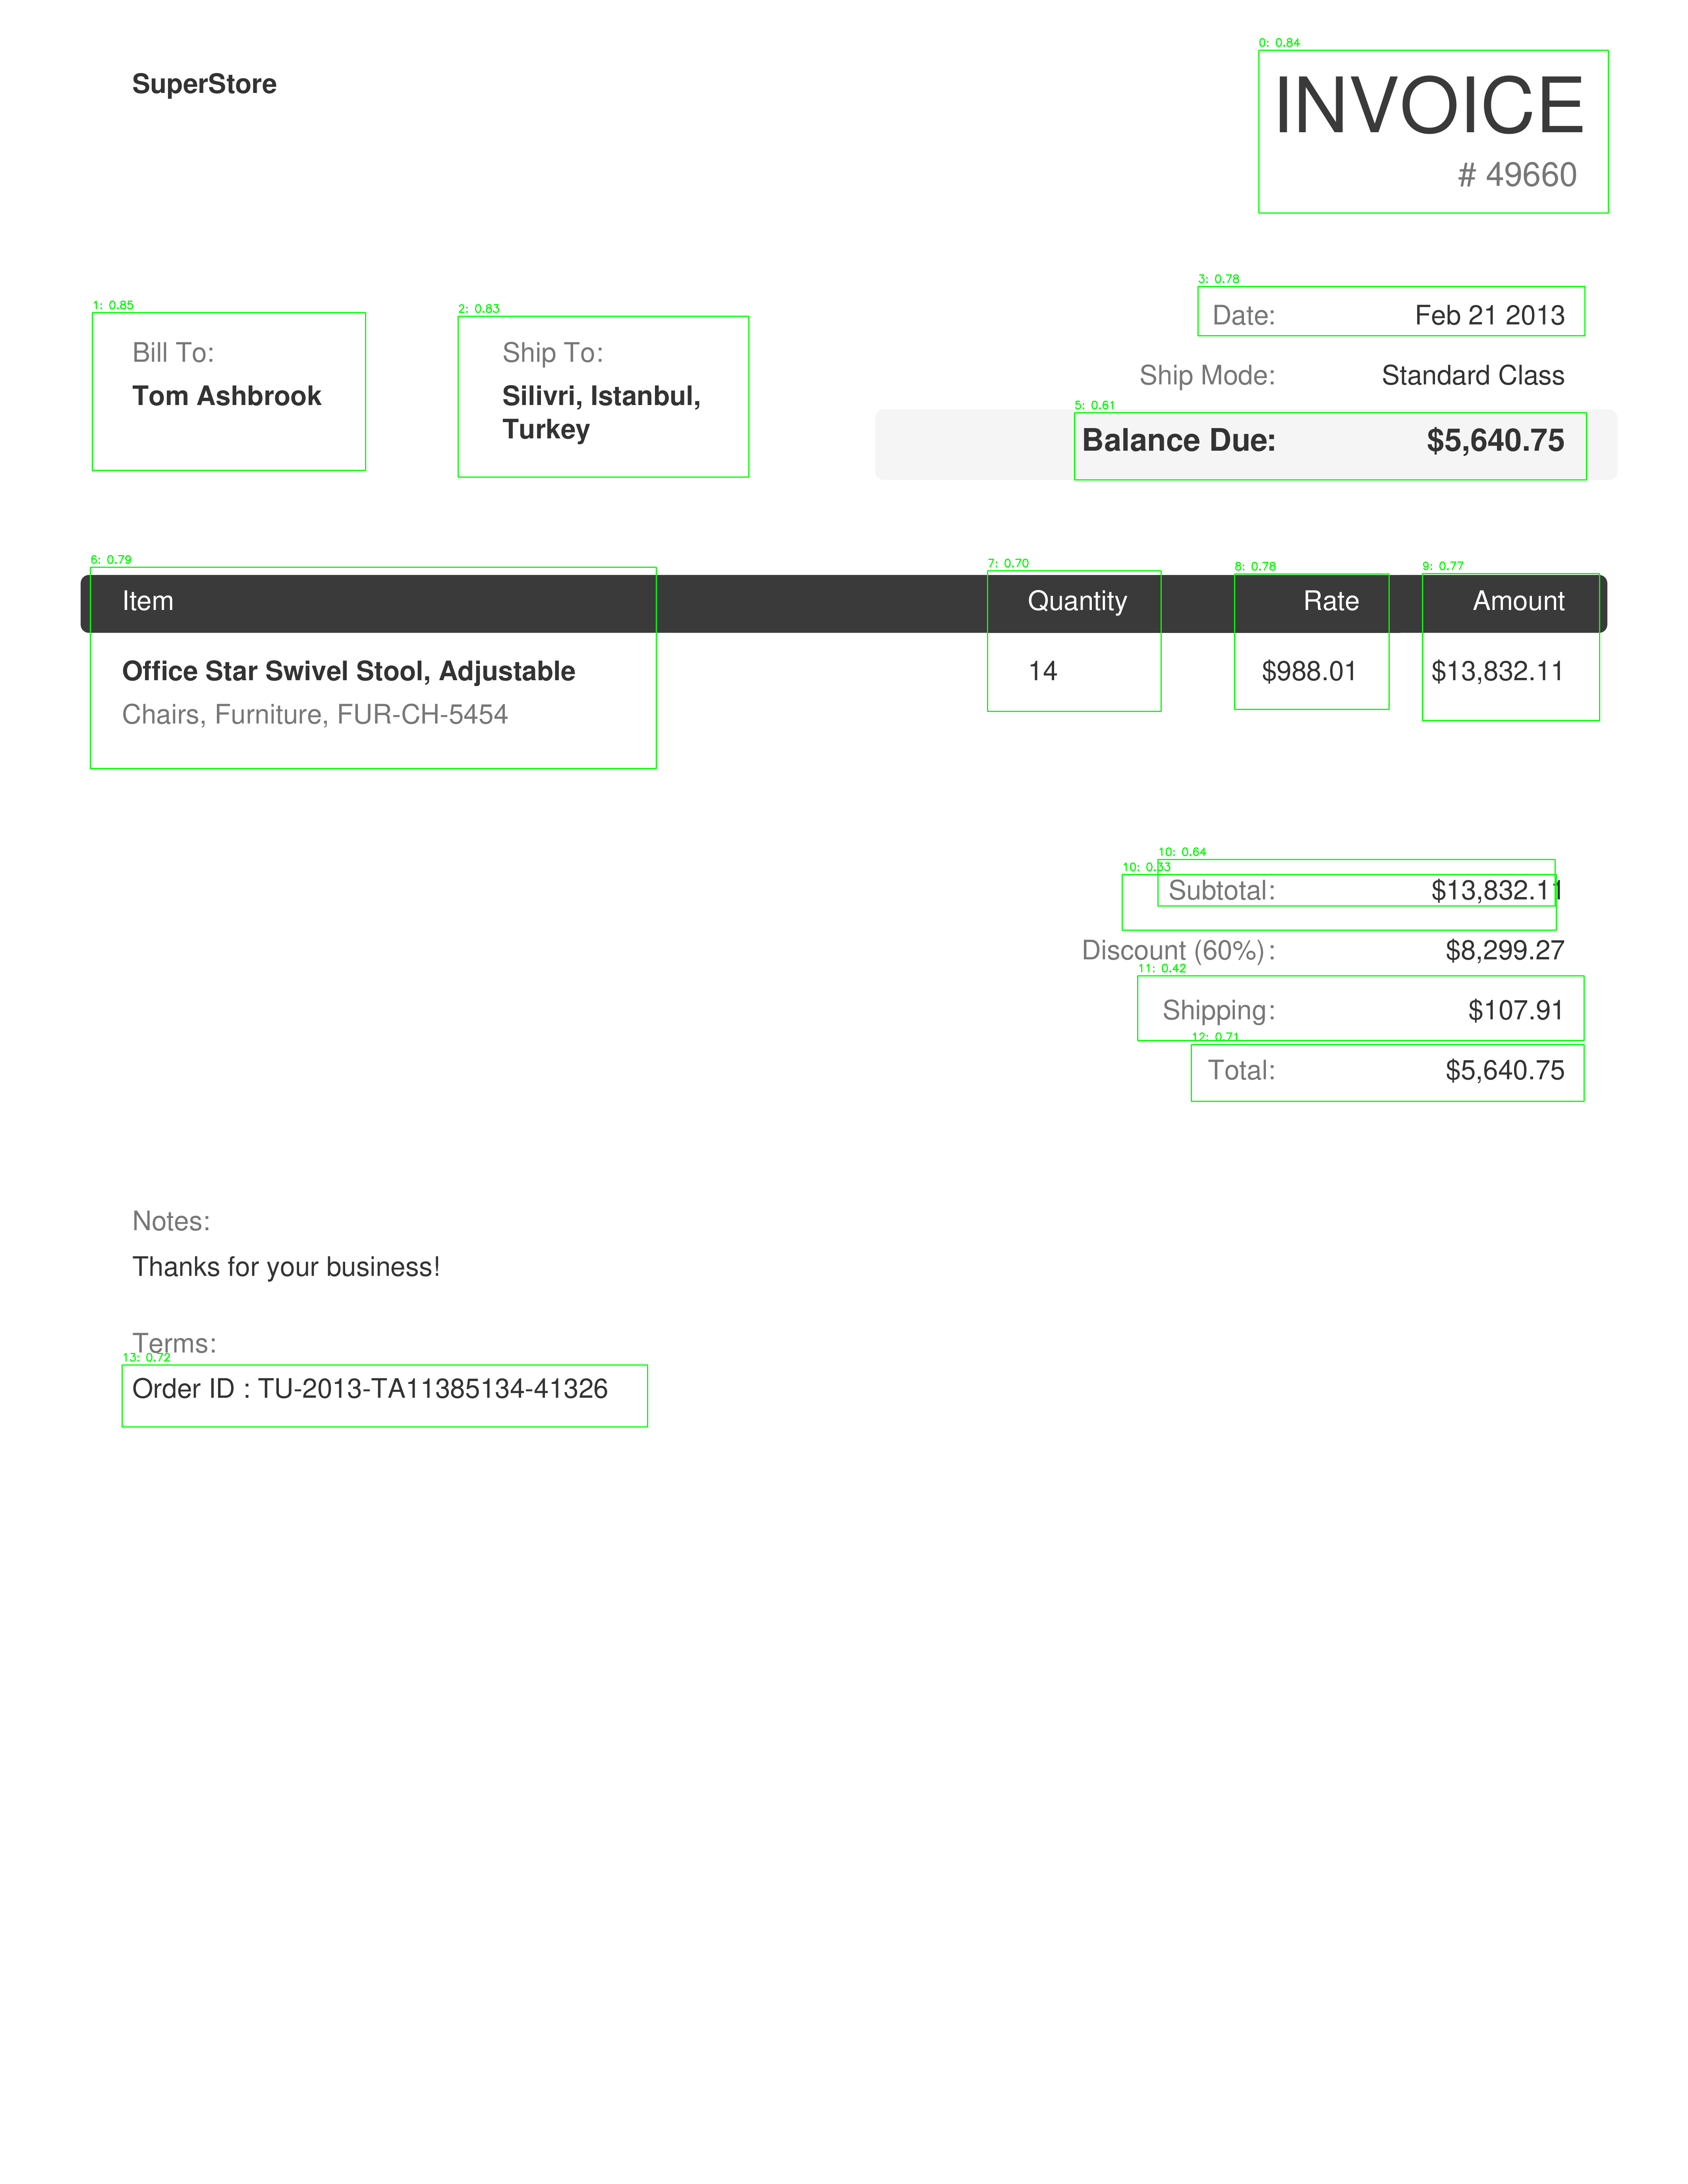

tensor([[2.32801e+02, 7.87187e+02, 9.20181e+02, 1.18408e+03, 8.51089e-01, 1.00000e+00],
        [3.16979e+03, 1.26799e+02, 4.04920e+03, 5.36535e+02, 8.38880e-01, 0.00000e+00],
        [1.15306e+03, 7.96978e+02, 1.88582e+03, 1.20182e+03, 8.29961e-01, 2.00000e+00],
        [2.27997e+02, 1.42838e+03, 1.65293e+03, 1.93596e+03, 7.90973e-01, 6.00000e+00],
        [3.10821e+03, 1.44527e+03, 3.49740e+03, 1.78636e+03, 7.77698e-01, 8.00000e+00],
        [3.01626e+03, 7.21037e+02, 3.99055e+03, 8.45220e+02, 7.76621e-01, 3.00000e+00],
        [3.58139e+03, 1.44477e+03, 4.02706e+03, 1.81441e+03, 7.68153e-01, 9.00000e+00],
        [3.07025e+02, 3.43793e+03, 1.63037e+03, 3.59335e+03, 7.22949e-01, 1.30000e+01],
        [2.99918e+03, 2.63045e+03, 3.98858e+03, 2.77302e+03, 7.08974e-01, 1.20000e+01],
        [2.48653e+03, 1.43739e+03, 2.92356e+03, 1.79148e+03, 7.03601e-01, 7.00000e+00],
        [2.91522e+03, 2.16447e+03, 3.91553e+03, 2.28126e+03, 6.43983e-01, 1.00000e+01],
        [2.70530e+03, 1.03976e+0

In [11]:
# testing on random image
plot_and_save_bboxes('/kaggle/working/yolo_dataset/test/images/invoice_Tom Ashbrook_49660_page_0.png',model,'/kaggle/working/invoice_Amy Hunt_37363_page_0.png')

# Initiating Text Extraction Process

In [12]:
test_image_paths = glob.glob(os.path.join('/kaggle/working', test_images_dir, '*.png'))
test_image_paths.sort()

In [13]:
# Preprocessing functions
def apply_clahe(image):
    if len(image.shape) == 2:  # Grayscale image
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        return clahe.apply(image)
    else:  # Color image
        ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        y, cr, cb = cv2.split(ycrcb)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        y = clahe.apply(y)
        clahe_ycrcb = cv2.merge([y, cr, cb])
        return cv2.cvtColor(clahe_ycrcb, cv2.COLOR_YCrCb2BGR)

def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = apply_clahe(image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    denoised = cv2.fastNlMeansDenoising(thresh, None, 30, 7, 21)
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpened = cv2.filter2D(denoised, -1, kernel)
    return sharpened

# Function to extract text from bounding boxes
def extract_text_from_bboxes(image_path, bboxes):
    image = preprocess_image(image_path)
    extracted_text = []
    
    # Ensure bboxes are in integer format and valid
    bboxes = bboxes[bboxes[:, 4] > 0.25]  # Apply confidence threshold if needed
    for bbox in bboxes:
        x_min, y_min, x_max, y_max, conf, cls = map(int, bbox)
        # Handle cases where coordinates may be out of bounds
        x_min, y_min = max(x_min, 0), max(y_min, 0)
        x_max, y_max = min(x_max, image.shape[1]), min(y_max, image.shape[0])
        
        roi = image[y_min:y_max, x_min:x_max]
        
        # Optional: Save the region of interest for debugging
        # cv2.imwrite(f'roi_{x_min}_{y_min}.png', roi)
        
        text = pytesseract.image_to_string(roi, config='--psm 6')
        extracted_text.append(text.strip().replace('\n', ' '))
    return extracted_text


# Evaluating Extracted Text

In [14]:
# Test the OCR on a single image
sample_test_image = test_image_paths[5]
results = model(sample_test_image)
bboxes = results.xyxy[0].cpu().numpy()  # Extract bounding boxes as numpy array

extracted_text = extract_text_from_bboxes(sample_test_image, bboxes)
extracted_text

['Bill To: Tom Ashbrook',
 'INVOICE',
 'Ship To: Silivri, Istanbul, Turkey',
 'Office Star Swivel Stool, Adjustable Chairs, Furniture, FUR-CH-5454',
 '$988.01',
 'Date: Feb 21 2013',
 'AmOuTR $13,832.11',
 'Order ID : TU-2013-TA11385134-41326',
 'Total: $5,640.75',
 'Quantity 14',
 'Subtotal: $13,832.1',
 'Balance Due: $5,640.75',
 'Shipping: $107.91',
 'Subtotal: $13,832. 1°',
 'p Mode: Standard Class',
 'Discount (60%): $8,299.27']

In [32]:
text_list = []
for image in test_image_paths:
    results = model(image)
    bboxes = results.xyxy[0].cpu().numpy()
    extracted_text = extract_text_from_bboxes(image, bboxes)
    combined_text = "\n".join(extracted_text)
    text_list.append(combined_text)

# Initiating & Customizing NER

In [17]:
# Load the spaCy model
nlp = spacy.load('en_core_web_lg')

# Initialize the Matcher
matcher = Matcher(nlp.vocab)

# Define patterns for each entity type
patterns = {
    'Organization': [{'LOWER': 'bill'}, {'LOWER': 'to'}, {'IS_PUNCT': True}],  # Match 'Bill To:'
    'Address': [{'LOWER': 'ship'}, {'LOWER': 'to'}, {'IS_PUNCT': True}],  # Match 'Ship To:'
    'Order_ID': [{'LOWER': 'order'}, {'LOWER': 'id'}, {'IS_PUNCT': True}],  # Match 'Order ID :'
    'Total': [{'LOWER': 'total'}, {'IS_PUNCT': True}],  # Match 'Total:'
}

# Add patterns to the matcher
for label, pattern in patterns.items():
    matcher.add(label, [pattern])

def extract_entities_with_matcher(text):
    doc = nlp(text)
    entities = {"Date": None}
    
    for ent in doc.ents:
        if ent.label_ == "DATE" and entities["Date"] is None:
            entities["Date"] = ent.text
    
    matches = matcher(doc)
    headers = {label: None for label in patterns.keys()}
    
    # Detect headers and corresponding values
    for match_id, start, end in matches:
        match_id_str = nlp.vocab.strings[match_id]
        header = doc[start:end].text.strip()
        headers[match_id_str] = header
    
    # Extract values based on detected headers
    for label, header in headers.items():
        if header:
            # Extract the value following the header
            header_position = text.find(header)
            if header_position != -1:
                following_text = text[header_position + len(header):].strip()
                
                # Handle TOTAL specifically
                if label == 'Total':
                    value_match = re.search(r'\$[\d,]+\.\d{2}|\d+', following_text)
                    if value_match:
                        entities[label] = value_match.group().strip()
                else:
                    # Extract the next relevant line or text after the header
                    lines = following_text.split('\n')
                    if lines:
                        entities[label] = lines[0].strip()
    
    return entities

# Storing the results in DataFrame

In [33]:
import pandas as pd

l1 = []
for i, text in enumerate(text_list):
    result = extract_entities_with_matcher(text)
#     result.tolist()
    l1.append(result)
    
df = pd.DataFrame(l1)
df

df.to_csv

,Date,Organization,Address,Order_ID,Total
0,Jan 08 2013,Susan Mackendrick,"Cologne, North Rhine-Wesiphalia, Germany",ES-2013-SM2090548-41 282,"$2,851.16"
1,4\nDate,Thea Hendricks,"Kuching, Sarawak, Malaysia",IN-2013-TH21 10078-41287,"$2,845.85"
2,Jan 03 2013,Theone Pippenger,"Tamworth, England, United Kingdom",ES-2013-TP21130139-41277,"$3,448.54"
3,Jan 12 2013,Theresa Coyne,"Melbourne, Victoria, Australia",IN-2013-TC211457-41286,"$11,645.39"
4,Jan 12 2013,Theresa Coyne,"Melbourne, Victoria, Australia",IN-2013-TC211457-41286,"$1,232.75"
5,Feb 21 2013,Tom Ashbrook,"Silivri, Istanbul, Turkey",TU-2013-TA11385134-41326,"$5,640.75"
6,Jan 15 2013,Tonja Turnell,"Kuala Lumpur, Kuala Lumpur, Malaysia",IN-2013-TT2146078-41289,"$1,353.77"
7,7\nDate,Trudy Glocke,"Kuantan, Pahang, Malaysia",IN-2013-1TG2164078-41299,"$7,325.56"
8,Jan 10 2013,Trudy Schmidt,"London, England, United Kingdom",IT-2013-1TS21655139-41284,"$12,725.04"
9,Jan 19 2013,Valerie Dominguez,"Northampton, England, United Kingdom",ES-2013-VD21670139-41293,$718.64
